# Cross-Sectional Trading strategies




---
**🎯 Learning Objectives**

1. **Contrast timing vs. cross-sectional approaches**  
   Recognize that characteristic-based strategies keep aggregate market exposure roughly constant and instead shift weight across individual stocks according to firm-level signals.

2. **Master the four-step portfolio recipe**  
   *Build a signal* → *sort stocks each month* → *weight within buckets (equal or market-cap)* → *form the long-short spread (top – bottom)*, always using information that is known on the trade date.

3. **Construct the market-cap-weighted benchmark correctly**  
   Compute market capitalizations from lagged price × shares-outstanding and show how to aggregate them to the total-market portfolio, avoiding look-ahead bias.

4. **Organize large equity data sets efficiently**  
   Work with “stacked” (date-firm) data frames, merge CRSP returns with characteristics, and reshape the grouped returns so they are ready for analysis and plotting.

5. **Code a reusable function that maps any signal to portfolios**  
   Generalize the recipe into a single function that takes a signal (`X`), number of groups, and weighting choice, and then delivers decile returns, cumulative-return plots, and the long-short series.

6. **Develop empirical intuition about trade-offs**  
   Explore how the number of groups, the dispersion of the signal, and the choice of weights influence the return spread, volatility, and diversification of the resulting portfolios.



---



## Libraries and all that

In [ ]:
# !pip install wrds

In [ ]:
# import psycopg2 
# import wrds

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web

import datetime as dt

from dateutil.relativedelta import *
from pandas.tseries.offsets import *

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

## The Market-Cap Weighted strategy


As a warm up for you first factor construction we will construct the returns on the market portfolio

- In some way that is the most important strategy ever 

- It completely revolutionized Wall Street leading to the rise of index funds 

How to do it?

* start with a vector of market capitalization for all relevant assets $M_t=[m_t^{AAPL},m_t^{GOOG},m_t^{TSLA},..]$ 

$$m_t^{AAPL}=P^{AAPL}_t\times SharesOutstanding^{AAPL}$$

The strategy then set the weights simply to 

$$X_t=\frac{M_t}{\sum_i^Im^i_t}$$

So at end of month **t** you look at the market caps, construct the weights, and buy the assets with weights $X_t$ (at prices $P_t$) to earn

$$R^{mcap}_{t+1}=X_tR_{t+1}$$

at the end of the next month.

That is you pay $P_t$ and get back $P_{t+1}+D_{t+1}$, hence return $R_{t+1}=\frac{P_{t+1}+D_{t+1}}{P_t}$

This portfolio has nice properties

1. This portfolio is very easy to trade. It does not require re-balancing as your weights naturally go up if the stock rallies and go down if the stock crashes
  
2. You can implement this approach to any subset of firms (for example SP500 or Russel2000) are market cap indexes that track a particular universe of stocks and we will be using it in our characteristic-based portfolios shortly

3. By buying proportionally to market cap you never have to build a huge position in a tiny stock--so this is much easier to trade!

    - Equal weighted portfolio tend to be very hard to trade and the alphas that you get there are mostly a mirrage, unless you focus on large caps


>**Steps**
>1. Get firm level monthly return data with market capitalizations
>2. clean up/organize the data set
>3. Make sure to lag the market cap signal so that we use prices from last month to trade at the start of this month ( we could also skip another month to be extra sure)
>4. Construct the weighted average of returns across stocks for each date

###  Stacked Datasets

>* We will now work with large data sets
>* Data sets that include all US stocks
>* Because there are many stocks, we have to work with it stacked

**Organizing the data**

The objective here is to have a data set with 

- Security identifier
- Date of the information
- Monthly return of the firm in that month
- Market capitalization of the firm in that month

In [50]:

########################
### Download CRSP monthly data
###################
# conn=wrds.Connection() 
# crsp = conn.raw_sql("""
#                       select a.permno,a.permco, a.date, b.shrcd, b.exchcd,b.ticker,
#                       a.ret, a.shrout, a.prc,a.retx
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/31/2002' and '12/31/2024'
#                       and b.exchcd between 1 and 3
#                       and b.shrcd between 10 and 11
#                       """, date_cols=['date']) 

# crsp.to_pickle('../../assets/data/crspm2002_2024.pkl')
# # variables downloaded
# # 1. Permno-- are unique indentifier to a security 
# # (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# # 2. shrco is the type of share: common share, ADR, ETF, ....
# # we will focus on common shares

# # 3. exchcd is the code of the exchange where the stock was originally listed
# # we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# # 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# # 5. date is the trading date of the return

#####
# get pre downloaded data

url = "https://github.com/amoreira2/UG54/blob/main/assets/data/crspm2002_2024.pkl?raw=true"
crsp = pd.read_pickle(url)
crsp

,permno,permco,date,shrcd,exchcd,ticker,ret,shrout,prc,retx
0,10066,6331,2002-02-28,11,2,FCM,-0.333333,43809.0,0.040,-0.333333
1,10066,6331,2002-03-28,11,2,FCM,0.000000,43809.0,0.040,0.000000
2,10066,6331,2002-04-30,11,2,FCM,-0.250000,43809.0,0.030,-0.250000
3,10066,6331,2002-05-31,11,2,FCM,0.333333,43809.0,0.040,0.333333
4,10066,6331,2002-06-28,11,2,FCM,-0.250000,43809.0,0.030,-0.250000
...,...,...,...,...,...,...,...,...,...,...
144996,78830,11893,2006-06-30,11,3,TRUE,-0.048387,2263.0,-23.010,-0.048387
144997,78830,11893,2006-07-31,11,3,TRUE,0.030204,2263.0,-23.705,0.030204
144998,78830,11893,2006-08-31,11,3,TRUE,-0.031850,2233.0,22.950,-0.031850
144999,78830,11893,2006-09-29,11,3,TRUE,0.006972,2233.0,23.110,0.006972


## Data Cleaning and Organization

In [51]:

crsp=crsp[['permco','permno','ticker','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)

# Line up date to be end of month 
crsp['date']=crsp['date']+pd.offsets.MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 

# sort by permno and date and also drop duplicates
crsp=crsp.sort_values(by=['permno','date']).drop_duplicates()

crsp

,permco,permno,ticker,date,ret,shrout,prc,me
212,7953,10001,EWST,2002-01-31,-0.013100,2566.0,11.30000,2.899580e+04
213,7953,10001,EWST,2002-02-28,-0.053097,2569.0,10.70000,2.748830e+04
214,7953,10001,EWST,2002-03-31,-0.015888,2571.0,10.40000,2.673840e+04
215,7953,10001,EWST,2002-04-30,-0.043269,2571.0,9.95000,2.558145e+04
216,7953,10001,EWST,2002-05-31,0.014824,2571.0,10.09750,2.596067e+04
...,...,...,...,...,...,...,...,...
144132,53453,93436,TSLA,2024-08-31,-0.077391,3194640.0,214.11000,6.840044e+08
144133,53453,93436,TSLA,2024-09-30,0.221942,3207000.0,261.63000,8.390474e+08
144134,53453,93436,TSLA,2024-10-31,-0.045025,3210060.0,249.85001,8.020335e+08
144135,53453,93436,TSLA,2024-11-30,0.381469,3210060.0,345.16000,1.107984e+09


In [52]:
from pandas.tseries.offsets import *
crsp=crsp[['permco','permno','ticker','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
crsp[['permco']]=crsp[['permco']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)
crsp_me=crsp.groupby(['date','permco'])['me'].sum().reset_index()


# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])

# drop me column and replace with the sum me
crsp=crsp.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp=pd.merge(crsp, crsp_me, how='inner', on=['date','permco'])

# sort by permno and date and also drop duplicates
crsp=crsp.sort_values(by=['permno','date']).drop_duplicates()



## Stacked Datasets structure

> Take time to note the stacked structure of the data set
>-  Before with a "rectangular" data set  we need two coordinates, row and column, to identify the return of an asset in a particular date
> - It was easier to manipulate but we would need one dataframe for each different firm variable: In this case one for return and one for market equity
> - As we work with many signals, this becomes intractable because we would need many dataframes
> - As we work with many asset, this would become intractable because we would need dataframes with many columns with most locations empty. This is very inefficient and hard to manipulate
> - Now we need two coordinates both in columns, "date" and "permco", to identify one firm-date observation, and then a third coordinate, the column names to identify the particular variable for that firm-date pair

In [53]:
crsp.head()

,permco,permno,ticker,date,ret,me
0,7953,10001,EWST,2002-01-31,-0.013100,28995.8000
1,7953,10001,EWST,2002-02-28,-0.053097,27488.3000
2,7953,10001,EWST,2002-03-31,-0.015888,26738.4000
3,7953,10001,EWST,2002-04-30,-0.043269,25581.4500
4,7953,10001,EWST,2002-05-31,0.014824,25960.6725


## constructing portfolio weights

- We are constructing a market capitalization weighted strategy
- It is key that the weights are know at the time of portfolio formation
- So we need to lag our portfolio weights

>**Lagging the market cap signal**
>- We use the method `.shift(d)` which "lags" the data by d periods.
>- It is important that we have our data set sorted by date
>- ``shift(d)`` simply shifts the rows. So you have to make sure that it is actually lagging by date. 
>The way to do that is to  `groupby` security and applying the shift within security.

>Why this is important?
>- Because the data set is stacked so when you shift the first month of security n, it will end up returning the last month of security n-1.
>- By "grouping by" we correctly assign a missing value there since we don't have the data

In [54]:
# sort by permno and date and set as index
crsp=crsp.sort_values(by=['permno','date'])
crsp['me_l1']=crsp.groupby(['permno']).me.shift(1)
crsp

,permco,permno,ticker,date,ret,me,me_l1
0,7953,10001,EWST,2002-01-31,-0.013100,2.899580e+04,NaN
1,7953,10001,EWST,2002-02-28,-0.053097,2.748830e+04,2.899580e+04
2,7953,10001,EWST,2002-03-31,-0.015888,2.673840e+04,2.748830e+04
3,7953,10001,EWST,2002-04-30,-0.043269,2.558145e+04,2.673840e+04
4,7953,10001,EWST,2002-05-31,0.014824,2.596067e+04,2.558145e+04
...,...,...,...,...,...,...,...
1130765,53453,93436,TSLA,2024-08-31,-0.077391,6.840044e+08,7.413801e+08
1130766,53453,93436,TSLA,2024-09-30,0.221942,8.390474e+08,6.840044e+08
1130767,53453,93436,TSLA,2024-10-31,-0.045025,8.020335e+08,8.390474e+08
1130768,53453,93436,TSLA,2024-11-30,0.381469,1.107984e+09,8.020335e+08


## Portfolio Weights

- We now want to compute the returns of our portfolio
- We need to start with the weights

$$ W_i=\frac{Marketcap_i}{\sum MarketCap_i}$$


⚡ ⏰ Question: Group A-B ⚡

- Write the code that constructs the vector of weights for the date '2015-06-60'
- Write the core that returns that the portfolio return in data date


In [ ]:
_temp=crsp[____==___]
W=_temp[]/(_temp[___].___)
_temp[___]@W

,permco,permno,ticker,date,ret,me,me_l1
4,7953,10001,EGAS,2015-06-30,0.030000,1.080779e+05,104880.00
34,7975,10025,AEPI,2015-06-30,0.103338,2.816856e+05,255303.09
57,7976,10026,JJSF,2015-06-30,0.029963,2.068644e+06,2014889.80
176,7978,10028,DGSE,2015-06-30,0.116750,5.473862e+03,4901.60
295,7980,10032,PLXS,2015-06-30,-0.035180,1.474587e+06,1528355.40
...,...,...,...,...,...,...,...
451180,53446,93428,BSFT,2015-06-30,-0.053136,1.016012e+06,1063901.40
451216,53447,93429,CBOE,2015-06-30,-0.022215,4.743538e+06,4884839.96
451259,53451,93433,VLTC,2015-06-30,-0.138719,5.123420e+04,59472.96
451281,53427,93434,SANW,2015-06-30,0.088071,6.565552e+04,59524.92


## Portfolio returns

⚡ ⏰ Question: Group C-E ⚡

Complete the code

In [ ]:
def portreturn(x):
    return (x[]/x[].sum())@x[]

#try first if it works in one date

portreturn(_temp)

# no apply to all dates
Rmkt=crsp.__([___]).apply(portreturn)

What is the code that does each step?
>- The `X` method groups the data by month so we obtain the return of the portfolio in that month
>-  the code `Y` has the weights in a given date, which for each date will return a vector that adds up to one. 
>- the code  `Z` multiplies the return of each asset by the weight 
>- the code `W`  sum all up to get the return of the portfolio

Lets compare our factor with the one ken french website

<AxesSubplot:xlabel='Date'>

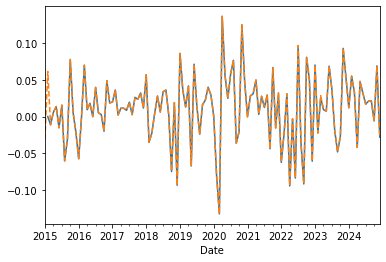

In [23]:
#Lets look at the cumulative return
df=get_factors('CAPM',freq='monthly')
(Rmkt).plot()
(df['Mkt-RF']+df['RF'])['2015':'2024'].plot(linestyle='dashed')

**Things to try and think about**


- Suppose you lag market cap 2 months instead of 1 does it make any difference? Do you expect there is any difference
- Suppose you drop the stocks with "negative" prices (i.e. stocks that didn't trade in the last day of the month), do you expect any difference? Does it make a difference? 

I want  everyone to stop and think about how one would approach the problem below. 
Please chat with your group!

- Harder: Suppose you wanted to construct something "like" the SP500? I.e. do market cap weights but only for the 500 largest firms in a given month. How would you do that?

## Characteristic-Based Strategies

* So far we have looked at strategies that go in and out of a particular asset according to a signal. 

* Now we will look at strategies that trade on asset characteristics



**The  recipe**

1. Construct a characteristic for each stock. 
    - It can be based on accounting data (aka fundamentals), return data, textual data from earning calls, twitter activity, ownership, shorting activity, satellite images--ANYTHING
    - What is important is that for each stock in each date you have a value for this characteristic
    - This characteristic must vary across firms
    - And you have a sense/theory of how this characteristic relates to expected returns
    
2. On a given date sort stocks by this characteristic. 
    - It is key that this characteristic is in fact known at sorting date!
    - Extremely careful not to introduce "look-ahead" bias
    
3. Construct portfolios by dividing stocks in deciles/quintiles to form portfolios of stocks that have similar characteristic
    - You can either equal-weight or value-weight or volume-weights or signal-weight within portfolio
    - Value-weighed portfolios are easier to trade, but if you are focused on large caps, you can go with either
    - But what is important is that each portfolio will have stocks of have very different characteristic values
    
4. Construct the long-short where you go long portfolio "10" and short portfolio "1" (or vice versa) but the point is to take a bet on the characteristic spread 





>**The goal here is to produce Alpha**

> - this is a simple and algorithimic  way to implement your idea in a way that harvest the benefits of diversification
> - Instead of betting on Apple because it is exposed to tariffs, build a tariff exposure "characteristic"


**From "names"  to characteristics**

* The  sorting by date keeps the stocks inside the portfolios with similar characteristics
* This sorting will "work" if these characteristics are good proxies for the behavior of the stock returns 
* Indeed, the key is that each portfolio has stocks of vastly different characterisitcs and keeps churning as firms change
  * Let's take MSFT (microsoft) as an example:
  * MSFT transitioned from being small in the 80's to be gigantic in the 90's, as a result, it moved up from the small portfolio to the big portfolio
  * During the Tech boom when MSFT had a huge valuation relative to it's book value, it went to the low BM portfolio
  * But then MSFT transtioned back to the high BM portfolio once it's market valuation collapsed in the aftermath of the techbubble
  * Now with AI, MSFT is back into the low BM portfolio
  * During these 80 years MSFT changed dramatically and the characteristic changed with it...

* The key is that firms' characteristics change over time, by constructing  portfolios, we hope to estimate some stable parameters (for example, alpha and beta)

* But it doesn't work always, if you use the first letter of stock ticker to construct 26 portfolios you are unlikely to get spread in average returns and most likely each portfolio will resemble the market portfolio but with much more volatility.
* The characteristics have to capture the right economics/market dynamics

## Implementing the recipe

1. We will start with a constructed characteristic $c_{i,t}$
2. Produce 10 portfolios based on this characteristic
    - Members of portfolio 1 in date t have the bottom 10% value of the characteristics in date t
    - Members of portfolio 2 in date t have characteristic between 10% and 20% of the characteristics in date t
3. Given these memberships for each date we will the construct return by buying at the closing price of date t and selling at the closing on date t+1
    - We will typically work with monthly data, so this should read as the closing of the last date of months t and t+1
   

We start by loading a dataset where you have many signals






## Our Characteristic  data

- They are based on various accounting and market based information
- The construction of each signal is full of painful details and there are many details that matter
- Here are some of the variables

  - permno identifies the company in a way that is invariant to ticker changes
  - re is the excess return on the stock
  - rme is the market excess returns ( the same across all stocks in a given date)
  - rf is the risk-free rate (also the same across stocks) 
  - size is log market cap
  - Value is Book-to-market (Why is this called value?)


  There are many other characteristics

  For now all we need to know is that all the characteristics are already lagged 1 month, so we can form portfolios directly based on them without lagging

In [56]:
url = "https://github.com/amoreira2/UG54/blob/main/assets/data/characteristics20022016.pkl?raw=true"

df_X = pd.read_pickle(url)
df_X=df_X.reset_index()
df_X.date=df_X.date+pd.tseries.offsets.MonthEnd()
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163913 entries, 0 to 163912
Data columns (total 34 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       163913 non-null  datetime64[ns]
 1   permno     163913 non-null  int64         
 2   re         163913 non-null  float64       
 3   rf         163913 non-null  float64       
 4   rme        163913 non-null  float64       
 5   size       163913 non-null  float64       
 6   value      163913 non-null  float64       
 7   prof       163913 non-null  float64       
 8   fscore     163913 non-null  int64         
 9   debtiss    163913 non-null  int64         
 10  repurch    163913 non-null  int64         
 11  nissa      163913 non-null  float64       
 12  growth     163913 non-null  float64       
 13  aturnover  163913 non-null  float64       
 14  gmargins   163913 non-null  float64       
 15  ep         163913 non-null  float64       
 16  sgrowth    163913 no

## Group assets by signal

1. Select our characteristic

2. assign stocks to groups. These groups will identify which portfolio each stock belongs in a particular date according to their relative ranking of the characteristic in that date

* We will do this by applying the function [pd.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)  to the chosen characteristic. This will "cut" the signal distribution in the chosen number of groups. 

* The important aspects is that we will be applying this date by date. This make the strategy cross-sectional because you are using the distribution of the signal as given date to do the grouping-- Very much like curved grades by cohort

> * Details
   - `duplicates='drop'`: In case there are two stocks with exactly the same signal that are exactly in the cutoff of the groups, we drop one of the observations 
   - ` labels=False`: The method simply label the groups with numbers. For example if `ngroups=10` then it will assign `0` to the stocks with the  bottom 10% returns in a given date, `1` to stocks with returns in between 10% and 20% of the signal distribution on a given date, ..., and 9 for stocks in the top 10% (signal in between 90% and 100% of the return distribution on a given date) .
   

In [ ]:
df_X['X_group']=df_X.groupby(['date'])['value'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
df_X[['date','permno',X,'X_group']]

,date,permno,value,X_group
0,2002-01-31,10078,-2.471709,0
1,2002-01-31,10104,-3.183480,0
2,2002-01-31,10107,-1.696643,2
3,2002-01-31,10108,-1.461118,3
4,2002-01-31,10119,-0.521094,7
...,...,...,...,...
163908,2016-12-31,93420,1.049163,9
163909,2016-12-31,93422,0.829353,9
163910,2016-12-31,93423,-2.128977,1
163911,2016-12-31,93429,-3.001095,0


## Calculate the portfolio return


We need weights where they must add up to 1.

$$\sum_i^I w_{it} r_{it}$$

We do this so when we do the long-short we have a clear notion of "book size"

if you go 100 times the long short, you know this means buy 100 dollars of the long and selling 100 dollars of the short

We will start with equal-weighted returns which is easy and it is simply an average of the returns in the portfolio in a given date ( the wrights is 1/I)

⚡ ⏰ Question: Group F-G ⚡

Complete the code below so we obtain the output below with the cumulative returns for each portfolio 

<AxesSubplot:xlabel='date'>

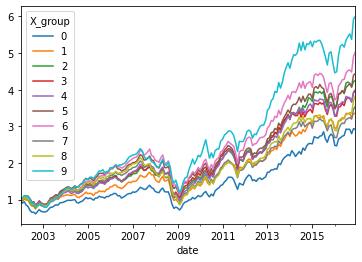

In [ ]:

ret_byX_ew =df_X.groupby([__,__]).apply(lambda x: np.mean(__+__))
# what this code below does?
ret_byX_ew=ret_byX_ew.unstack(level=-1)

(__+__).cumprod().plot()

## Market cap weighted returns

What about for market cap weights?

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_24324\2208835029.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_byX_vw =df_X.groupby(['date','X_group']).apply(lambda x:(x.re*x.me_l1).sum()/x.me_l1.sum())


<Axes: xlabel='date'>

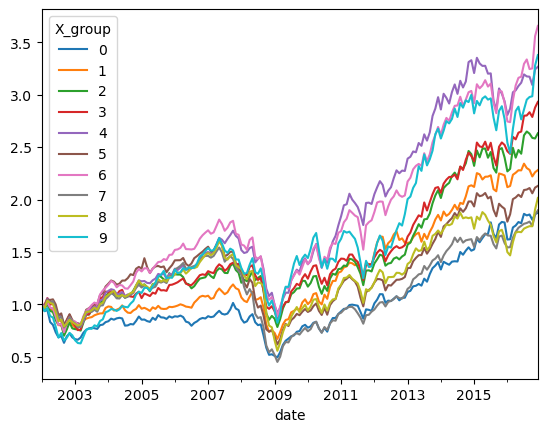

In [ ]:
df_X['me_l1']=np.exp(df_X['size'])
ret_byX_vw =df_X.groupby(['date','X_group']).apply(lambda x:((x.__+x.__)*x.__).sum()/(x.__.sum()))
ret_byX_vw=ret_byX_vw.unstack(level=-1)
(ret_byX_vw+1).cumprod().plot()

## The evolution of a firm through the lens of a characteristic

-If we focus on a particular stock, we can see how it's portfolio membership changed over time.

-You can check you that some characteristics are fairly persistent and change only slowly over time

-While others, like momentum change very frequently.

- We will look at the 5 largest firms as of 2002

- I did a query to get their tickers so we know what we are looking at

permno ticker                 comnam  
  10107   MSFT         MICROSOFT CORP  
  11850    XOM       EXXON MOBIL CORP  
  21936    PFE             PFIZER INC  
  70519      C          CITIGROUP INC  
  77418    AOL  A O L TIME WARNER INC  

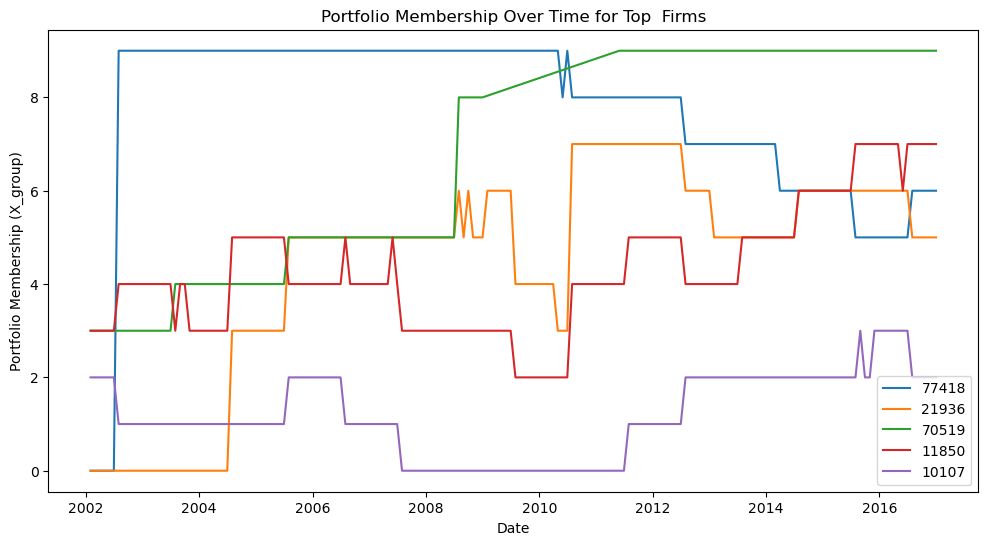

In [ ]:
# lets select the top 5 firms with highest market capitalization in Jan 2002
_temp=df_X.sort_values(by=['date','size'])
top=_temp[_temp.date=='2002-01-31'].tail(5).permno.tolist()
print(top)
## In case we want to change the characteristic
df_X['X_group']=df_X.groupby(['date'])['value'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
# LETS LOOOK AT THEIR PORTFOLIO MEMBERSHIP OVER TIME
plt.figure(figsize=(12,6))
for firm in top:
    data = df_X[df_X.permno==firm][['date','X_group']]
    plt.plot(data['date'], data['X_group'], label=str(firm))
plt.xlabel('Date')
plt.ylabel('Portfolio Membership (X_group)')
plt.title('Portfolio Membership Over Time for Top  Firms')
plt.legend()
plt.show()



## Wrapping in a function

- We have all the code we need to write a function that takes our data and constructs a long-short strategy returns for any characteristic we have and for any choice of granularity (i.e. number of groups)
- The long short should got long the highest portfolio (9) and short the lowest (0)

⚡ ⏰ Question: All groups ⚡

- I want you to get together with your group and tell me how to build this function
- I want you to tell me which cells I need to copy, how to modify it, and what new code do we need



In [ ]:
def long_short(X='value', n_groups=10):

#complete the code

    return long_short_ret
long_short(X='value', n_groups=10)

date
2002-01-31    0.040104
2002-02-28    0.105311
2002-03-31    0.015371
2002-04-30    0.079384
2002-05-31    0.035573
                ...   
2016-08-31    0.019712
2016-09-30    0.012818
2016-10-31    0.014353
2016-11-30    0.054571
2016-12-31    0.019796
Length: 180, dtype: float64

## Portfolio formation tradeoffs: Diversification vs Signal Strength

* Why not sort in 100 groups instead on only 10? This way your top portfolio would have much higher average characteristics
* Why no simply focus on the stock with the highest characteristic?

  1. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.
  2. So  you have to trade-off strength of the signal against benefits of diversification


Lets look at this trade-off for Value, Profitability and Momentum


- Profitability is simply Gross Profits/Book Assets
- Momentum is the cumulative return in the last  12 months skipping the last month (next class!)



In [39]:
def long_short_stats(X='value', n_groups=10):
    r=long_short(X,n_groups)
    return r.std()*12**0.5

for g in [5,10,50,100]:
    print(f'Number of groups: {g}')
    print(long_short_stats('value',g))
    print(long_short_stats('mom',g))
    print(long_short_stats('prof',g))
    print('-------------------')

Number of groups: 5
0.08255392985128295
0.16600364967177128
0.08110923708672288
-------------------
Number of groups: 10
0.10275291207096139
0.2140897671349157
0.11537007514740719
-------------------
Number of groups: 50
0.15912031882198882
0.32389078360187246
0.16863395249433805
-------------------
Number of groups: 100
0.19292759374957438
0.3818200164373193
0.22228821463684753
-------------------



## Things to try


> - Look at different characteristics. Which ones create higher spread in average returns
> - Construct the long-short portfolio that goes long the high portfolio and short the low portfolio. What are the properties of this portfolio?
> - Which ones have alpha relative to the market in the sample? What do their betas look like?
> - When they perform poorly?
> - How correlated are the returns of the long-shorts of different characteristics?
> - What about interactions of characteristics? How Do you buy "profitable firms" at a good "value" Like Warren likes?

Important: 

- This is a short sample so things can  be done in class quickly
- To learn anything meaningful about risk-premiums you would want a longer sample



---
**📝 Key Takeaways**

- **Stacked data frames are the backbone** when working with thousands of stocks and multiple characteristics.  
- **Lagged market-cap weights should be the default**: they minimize turnover, reflect realistic trading capacity, and eliminate look-ahead bias.  
- **Characteristic-sorted portfolios isolate cross-sectional spreads** in the signal; the long-short “top minus bottom” position delivers a clean test of the signal’s pricing power.  
- **Portfolio design choices matter**: more groups widen the average-return spread but shrink the number of stocks per bucket; equal-weighting boosts the influence of small caps, while value-weighting is closer to how real money is run.  
- **A single, well-structured function automates experimentation** across different signals, making it easy to investigate which characteristics generate higher alpha, when they underperform, and how their long-short returns co-move.  
- **The core tension is signal strength versus diversification**: stronger signals often come with higher concentration and trading costs, so practical implementation always balances these forces.
---